In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import compute_class_weight
from collections import Counter
import keras

Get the input and label files from CSVs

In [35]:
def filter_sequences(x_sequences, y_sequences, model):
    filtered_x_sequences = []
    filtered_y_sequences = []
    if model == 'Model I':
        for x_seq, y_seq in zip(x_sequences, y_sequences):
            if np.any(y_seq[:, 1:] != 0) or (np.sum(y_seq[:, 0] != 0) < 2 and np.any(y_seq[:, 0] != 0)):
                filtered_x_sequences.append(x_seq)
                filtered_y_sequences.append(y_seq)
    else:
        for x_seq, y_seq in zip(x_sequences, y_sequences):
            if np.any(y_seq[:, 1:] != 0):
                filtered_x_sequences.append(x_seq)
                filtered_y_sequences.append(y_seq)
            
    return filtered_x_sequences,filtered_y_sequences
    

In [36]:
def get_train_test_splitted_data(label_files, input_files, global_mean, global_std, test_size=0.2, random_state=42):
    # Initialize lists to hold all sequences
    all_x_sequences = []
    all_y_sequences = []
    # Process each pair of input and label files
    for input_file, label_file in zip(input_files, label_files):
        # Load data
        input_df = pd.read_csv(input_file)
        if label_file.endswith('BORIS_method_II.csv'):
            model = 'Model II'
            label_df = pd.read_csv(label_file)
            labels = label_df.values / 100
        else:
            model = 'Model I'
            label_df = pd.read_csv(label_file, dtype=str, na_values=[])   
            column_names = ['Happy', 'Sad', 'Scared', 'Disgusted', 'Surprised', 'Angry']

            # Create a OneHotEncoder with predefined categories
            encoder = OneHotEncoder(categories=[column_names], handle_unknown='ignore')

            # Fit and transform the label data
            labels = pd.DataFrame(
                encoder.fit_transform(label_df).toarray(),
                columns=encoder.get_feature_names_out()
            )
        # Prepare features and labels
        features = (input_df.values - global_mean) / global_std
        
        # Ensure alignment of frames
        if features.shape[0] != labels.shape[0]:
            print(f"Mismatch in frames: {input_file}, {label_file}")
            continue
            
        # Sample sequences
        x_sequences, y_sequences = create_sequences(features, labels, SEQUENCE_LENGTH, STRIDE)
        filtered_x_sequences, filtered_y_sequences = filter_sequences(x_sequences, y_sequences, model)
        # Append to global lists
        if filtered_x_sequences and filtered_y_sequences:
            all_x_sequences.append(filtered_x_sequences)
            all_y_sequences.append(filtered_y_sequences)
            
    all_x_sequences = np.concatenate(all_x_sequences, axis=0)
    all_y_sequences = np.concatenate(all_y_sequences, axis=0)
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        all_x_sequences, all_y_sequences, test_size=test_size, random_state=random_state
    )

    # Convert to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # Shuffle, batch, and prefetch
    train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

    return train_dataset, test_dataset

In [46]:
def count_method_I(all_y_sequences):
    label_counts = Counter()
    emotion_labels = ['Happy', 'Sad', 'Disgusted', 'Surprised', 'Angry', 'Scared']
    # Loop through each y_sequence in all_y_sequences
    for y_sequence in all_y_sequences:
        # Loop through each label_vector (timestamp) in the sequence
        if np.all(y_sequence == 0):
            # Count as 'Neutral' if all values are zero
            label_counts['Neutral'] += 1            
        else:
            # Find the label corresponding to the max value (one-hot or normalized)
            label_index = np.argmax(y_sequence)
            label_counts[emotion_labels[label_index]] += 1
    
    # Compute the total number of labels
    total_labels = sum(label_counts.values())
    
    # Convert the Counter to a DataFrame
    df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
    
    # Add a new column for percentage
    df['Percentage'] = (df['Count'] / total_labels * 100).round(2).astype(str) + '%'  # Format as percentage
    
    # Reset the index to have labels as a column
    df = df.reset_index().rename(columns={'index': 'Label'})
    
    return df

gut_sequences = get_train_test_splitted_data(GUT_path_label_method_I, GUT_path_input, global_mean, global_std, test_size=0.3)
ituyu_sequences = get_train_test_splitted_data(ITU_YU_path_label_method_I, ITU_YU_path_input, global_mean, global_std, test_size=0.3)
maap_sequences = get_train_test_splitted_data(MAAP_path_label_method_I, MAAP_path_input, global_mean, global_std, test_size=0.3)
y_sequences = np.concatenate((gut_sequences, ituyu_sequences, maap_sequences))
print(count_method_I(y_sequences.reshape(-1,6)))

       Label  Count Percentage
0    Neutral   5557      75.3%
1        Sad    613      8.31%
2      Happy    348      4.72%
3  Surprised     42      0.57%
4      Angry     94      1.27%
5     Scared     94      1.27%
6  Disgusted    632      8.56%


In [18]:
def count_method_II(all_y_sequences):
    
    combined_df = pd.DataFrame(all_y_sequences)

    emotion_labels = ['Happy', 'Sad', 'Disgusted', 'Surprised', 'Angry', 'Scared']
    
    # Calculate the number of rows where each emotion is non-zero
    non_zero_counts = (combined_df != 0).sum()  # Counts of non-zero values per column
    total_rows = len(combined_df)  # Total number of rows
    print(total_rows)
    # Calculate the "Neutral" count (rows where all values are zero)
    neutral_count = (combined_df.sum(axis=1) == 0).sum()
    
    # Add the "Neutral" category to the counts
    non_zero_counts["Neutral"] = neutral_count
    
    result_df = pd.DataFrame(non_zero_counts.items(), columns=['Label', 'Count'])
    # Calculate the percentage for each label
    result_df['Percentage'] = ((result_df['Count'] / total_rows) * 100).round(2).astype(str) + '%'

        # Create a mapping from numbers to emotion labels
    label_mapping = {i: emotion_labels[i] for i in range(len(emotion_labels))}
    
    # Replace the numerical labels with the corresponding emotion labels
    result_df['Label'] = result_df['Label'].replace(label_mapping)
    
    # Display the result
    return(result_df)

In [2]:
# Constants
SEQUENCE_LENGTH = 20
STRIDE = 10
BATCH_SIZE = 32
INPUT_DIM = 515  # Number of features per frame (e.g., biosignals + embeddings)
OUTPUT_DIM = 6 

In [7]:
# Helper function to create random sequences
def create_sequences(features, labels, sequence_length, stride):
    x_sequences, y_sequences = [], []
    for i in range(0, len(features) - sequence_length + 1, stride):
        x_sequences.append(features[i:i + sequence_length])
        y_sequences.append(labels[i:i + sequence_length])
    return np.array(x_sequences), np.array(y_sequences)

# Initialize lists to hold all sequences
all_x_sequences = []
all_y_sequences = []
all_features = []

sources = ["GUT", "ITU-YU", "MAAP"]
base_path = "//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/"
input_files, label_files = [], []

for source in sources:
    input_files.extend(glob.glob(os.path.join(base_path, source, '*_input.csv')))
    label_files.extend(glob.glob(os.path.join(base_path, source, '*_BORIS.csv')))

input_files.sort()
label_files.sort()

i = 0
for input_file in input_files:
    input_df = pd.read_csv(input_file)
    all_features.append(input_df.values)

# Concatenate all features from all files to compute global mean and std
all_features = np.concatenate(all_features, axis=0)

num_columns = all_features.shape[1]
global_mean_zero = np.zeros(num_columns)
global_std_zero = np.zeros(num_columns)

# Compute column-wise statistics ignoring zeros
for col in range(num_columns):
    non_zero_col = all_features[:, col][all_features[:, col] != 0]  # Filter non-zero values
    if non_zero_col.size > 0:  # Avoid empty arrays
        global_mean_zero[col] = np.mean(non_zero_col)
        global_std_zero[col] = np.std(non_zero_col, ddof=1)  # Use sample std dev
    else:
        global_mean_zero[col] = 0  # Default if no non-zero elements
        global_std_zero[col] = 0

# Output results as ndarray
global_mean = np.array(global_mean_zero)
global_std = np.array(global_std_zero)


In [6]:
GUT_path_input = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_input.csv'))
ITU_YU_path_input = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_input.csv'))
MAAP_path_input = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_input.csv'))

GUT_path_label_method_I = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_BORIS_method_I.csv'))
ITU_YU_path_label_method_I = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_BORIS_method_I.csv'))
MAAP_path_label_method_I = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_BORIS_method_I.csv'))

GUT_path_label_method_II = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_BORIS_method_II.csv'))
ITU_YU_path_label_method_II = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_BORIS_method_II.csv'))
MAAP_path_label_method_II = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_BORIS_method_II.csv'))


In [ ]:
GUT_train_method_I, GUT_test_method_I = get_train_test_splitted_data(GUT_path_label_method_I, GUT_path_input, global_mean, global_std, test_size=0.3)
ITU_YU_train_method_I, ITU_YU_test_method_I = get_train_test_splitted_data(ITU_YU_path_label_method_I, ITU_YU_path_input, global_mean, global_std, test_size=0.3)
MAAP_train_method_I, MAAP_test_method_I = get_train_test_splitted_data(MAAP_path_label_method_I, MAAP_path_input, global_mean, global_std, test_size=0.3)

GUT_train_method_II, GUT_test_method_II = get_train_test_splitted_data(GUT_path_label_method_II, GUT_path_input, global_mean, global_std, test_size=0.3)
ITU_YU_train_method_II, ITU_YU_test_method_II = get_train_test_splitted_data(ITU_YU_path_label_method_II, ITU_YU_path_input, global_mean, global_std, test_size=0.3)
MAAP_train_method_II, MAAP_test_method_II = get_train_test_splitted_data(MAAP_path_label_method_II, MAAP_path_input, global_mean, global_std, test_size=0.3)

dataset_method_I = GUT_train_method_I.concatenate(ITU_YU_train_method_I).concatenate(MAAP_train_method_I)
dataset_method_II = GUT_train_method_II.concatenate(ITU_YU_train_method_II).concatenate(MAAP_train_method_II)

In [16]:
import pandas as pd
import numpy as np

all_features = []

for input_file in input_files:
    input_df = pd.read_csv(input_file)
    
    # Check if the DataFrame contains any NaN
    if input_df.isnull().values.any():
        print(f"NaN found in file: {input_file}")
    
    all_features.append(input_df.values)

In [13]:
# Zakomentowane bo się cykam
# path = r'S:\IO3-sessions\NEW STRUCTURE\de-earlyfusionthesis\Datasets'
# 
# tf.data.Dataset.save(dataset_method_I ,os.path.join(path, 'train_dataset_method_I'))
# tf.data.Dataset.save(GUT_train_method_I, os.path.join(path, 'GUT_train_method_I'))
# tf.data.Dataset.save(GUT_test_method_I, os.path.join(path, 'GUT_test_method_I'))
# tf.data.Dataset.save(ITU_YU_train_method_I, os.path.join(path, 'ITU_YU_train_method_I'))
# tf.data.Dataset.save(ITU_YU_test_method_I, os.path.join(path, 'ITU_YU_test_method_I'))
# tf.data.Dataset.save(MAAP_train_method_I, os.path.join(path, 'MAAP_train_method_I'))
# tf.data.Dataset.save(MAAP_test_method_I, os.path.join(path, 'MAAP_test_method_I'))
# 
# tf.data.Dataset.save(dataset_method_II ,os.path.join(path, 'train_dataset_method_II'))
# tf.data.Dataset.save(GUT_train_method_II, os.path.join(path, 'GUT_train_method_II'))
# tf.data.Dataset.save(GUT_test_method_II, os.path.join(path, 'GUT_test_method_II'))
# tf.data.Dataset.save(ITU_YU_train_method_II, os.path.join(path, 'ITU_YU_train_method_II'))
# tf.data.Dataset.save(ITU_YU_test_method_II, os.path.join(path, 'ITU_YU_test_method_II'))
# tf.data.Dataset.save(MAAP_train_method_II, os.path.join(path, 'MAAP_train_method_II'))
# tf.data.Dataset.save(MAAP_test_method_II, os.path.join(path, 'MAAP_test_method_II'))

In [342]:
path = r'S:\IO3-sessions\NEW STRUCTURE\de-earlyfusionthesis\Datasets'

tf.data.Dataset.save(dataset_method_I ,os.path.join(path, 'train_dataset_method_I_balanced'))
tf.data.Dataset.save(GUT_train_method_I, os.path.join(path, 'GUT_train_method_I_balanced'))
tf.data.Dataset.save(GUT_test_method_I, os.path.join(path, 'GUT_test_method_I_balanced'))
tf.data.Dataset.save(ITU_YU_train_method_I, os.path.join(path, 'ITU_YU_train_method_I_balanced'))
tf.data.Dataset.save(ITU_YU_test_method_I, os.path.join(path, 'ITU_YU_test_method_I_balanced'))
tf.data.Dataset.save(MAAP_train_method_I, os.path.join(path, 'MAAP_train_method_I_balanced'))
tf.data.Dataset.save(MAAP_test_method_I, os.path.join(path, 'MAAP_test_method_I_balanced'))

tf.data.Dataset.save(dataset_method_II ,os.path.join(path, 'train_dataset_method_II_balanced'))
tf.data.Dataset.save(GUT_train_method_II, os.path.join(path, 'GUT_train_method_II_balanced'))
tf.data.Dataset.save(GUT_test_method_II, os.path.join(path, 'GUT_test_method_II_balanced'))
tf.data.Dataset.save(ITU_YU_train_method_II, os.path.join(path, 'ITU_YU_train_method_II_balanced'))
tf.data.Dataset.save(ITU_YU_test_method_II, os.path.join(path, 'ITU_YU_test_method_II_balanced'))
tf.data.Dataset.save(MAAP_train_method_II, os.path.join(path, 'MAAP_train_method_II_balanced'))
tf.data.Dataset.save(MAAP_test_method_II, os.path.join(path, 'MAAP_test_method_II_balanced'))

In [4]:
path = r'S:\IO3-sessions\NEW STRUCTURE\de-earlyfusionthesis\Models'

In [3]:
path = r'S:\IO3-sessions\NEW STRUCTURE\de-earlyfusionthesis\Datasets'

train_dataset_path_I = os.path.abspath(os.path.join(path, 'train_dataset_method_I_balanced'))
GUT_test_path_I = os.path.join(path, 'GUT_test_method_I_balanced').replace("\\", "/")
ITU_YU_test_path_I = os.path.join(path, 'ITU_YU_test_method_I_balanced').replace("\\", "/")
MAAP_test_path_I = os.path.join(path, 'MAAP_test_method_I_balanced').replace("\\", "/")

train_dataset_path_II = os.path.abspath(os.path.join(path, 'train_dataset_method_II_balanced'))
GUT_test_path_II = os.path.join(path, 'GUT_test_method_II_balanced').replace("\\", "/")
ITU_YU_test_path_II = os.path.join(path, 'ITU_YU_test_method_II_balanced').replace("\\", "/")
MAAP_test_path_II = os.path.join(path, 'MAAP_test_method_II_balanced').replace("\\", "/")

# Load datasets
train_I = tf.data.Dataset.load(train_dataset_path_I)
GUT_test_I = tf.data.Dataset.load(GUT_test_path_I)
ITU_YU_test_I = tf.data.Dataset.load(ITU_YU_test_path_I)
MAAP_test_I = tf.data.Dataset.load(MAAP_test_path_I)

train_II = tf.data.Dataset.load(train_dataset_path_II)
GUT_test_II = tf.data.Dataset.load(GUT_test_path_II)
ITU_YU_test_II = tf.data.Dataset.load(ITU_YU_test_path_II)
MAAP_test_II = tf.data.Dataset.load(MAAP_test_path_II)

full_test_I = GUT_test_I.concatenate(ITU_YU_test_I).concatenate(MAAP_test_I)
full_test_II = GUT_test_II.concatenate(ITU_YU_test_II).concatenate(MAAP_test_II)

## MODEL I

In [16]:
@keras.saving.register_keras_serializable(package="my_package", name="custom_fn")
def masked_categorical_crossentropy(y_true, y_pred):
    """
    y_true: true labels, one-hot encoded. Shape (batch_size, sequence_length, OUTPUT_DIM)
    y_pred: predicted probabilities. Shape (batch_size, sequence_length, OUTPUT_DIM)
    """
    # Create a mask: 1 for valid labels (non-[0, 0, 0]), 0 for "Unknown" ([0, 0, 0])
    mask = tf.reduce_sum(y_true, axis=-1) > 0  # Shape: (batch_size, sequence_length)
    mask = tf.cast(mask, tf.float32)  # Convert boolean mask to float32 for multiplication
    
    # Compute categorical cross-entropy loss
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    # Apply the mask to the loss
    loss = loss * mask  # Zero out loss for "Unknown" labels
    
    # Return mean loss over valid labels
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [17]:
model_I = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQUENCE_LENGTH, INPUT_DIM)),    # Input shape: (sequence_length, features)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),  # LSTM layer to capture temporal patterns
    tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dense(32, activation='relu'),                 # Dense layer to reduce dimensionality
    tf.keras.layers.Dense(OUTPUT_DIM, activation='softmax')       # Output layer with sigmoid for continuous values between 0 and 1
])

In [18]:
model_I.compile(optimizer='adam', loss=masked_categorical_crossentropy, metrics=['accuracy'])

In [19]:
history = model_I.fit(train_I, epochs=100, batch_size=BATCH_SIZE)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - accuracy: 0.0858 - loss: 1.8065
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1227 - loss: 1.4991
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1570 - loss: 1.3751
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2160 - loss: 1.2438
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3162 - loss: 1.0700
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4682 - loss: 0.9031
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5208 - loss: 0.6871
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6234 - loss: 0.5253
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6198 - loss: 0.4390
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6482 - loss: 0.3256
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6534 - loss: 0.2517
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/st

In [20]:
model_I.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 20, 128)        │       296,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 922,484 (3.52 MB)

 Trainable params: 307,494 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 614,990 (2.35 MB)

In [21]:
# Evaluate the model
loss, acc = model_I.evaluate(full_test_I, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(acc))

5/5 - 2s - 392ms/step - accuracy: 0.5433 - loss: 0.7468
Untrained model, accuracy:  0.54%


In [22]:
model_I.save(os.path.join(path, 'model_method_I/model.keras'))

## MODEL II

In [5]:
@keras.saving.register_keras_serializable(package="my_package", name="custom_fn")
def masked_mean_squared_error(y_true, y_pred):
    """
    y_true: true labels, one-hot encoded. Shape (batch_size, sequence_length, OUTPUT_DIM)
    y_pred: predicted probabilities. Shape (batch_size, sequence_length, OUTPUT_DIM)
    """
    # Create a mask: 1 for valid labels (non-[0, 0, 0]), 0 for "Unknown" ([0, 0, 0])
    mask = tf.reduce_sum(y_true, axis=-1) > 0  # Shape: (batch_size, sequence_length)
    mask = tf.cast(mask, tf.float32)  # Convert boolean mask to float32 for multiplication
    
    # Compute categorical cross-entropy loss
    loss = tf.square(y_true - y_pred)
    
    # Apply the mask to the loss
    masked_loss = loss * mask[..., tf.newaxis]  # Zero out loss for "Unknown" labels
    
    # Return mean loss over valid labels
    return tf.reduce_sum(masked_loss) / tf.reduce_sum(mask)

In [6]:
model_II = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQUENCE_LENGTH, INPUT_DIM)),    # Input shape: (sequence_length, features)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),  # LSTM layer to capture temporal patterns
    tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dense(32, activation='relu'),                # Dense layer to reduce dimensionality
    tf.keras.layers.Dense(OUTPUT_DIM, activation='sigmoid')       # Output layer with sigmoid for continuous values between 0 and 1
])

In [7]:
model_II.compile(optimizer='adam', loss=masked_mean_squared_error, metrics=['mse'])

In [8]:
# Iterate through the dataset to extract labels
labels = []

for inputs, label in train_II:
    labels.append(label)

# Convert to a tensor or numpy array
y_train = np.concatenate(labels, axis=0)  # Stack labels into a single array
y_train_flat = y_train.reshape(-1, 6)  # Flattening the labels: (num_samples * 10, 6)
y_train_classes = np.argmax(y_train_flat, axis=-1)  # Get the class labels for each timestep (0 to 5)

# Calculate class weights based on the frequency of each class
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)

# Convert class_weights into a dictionary format for fit() function
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [9]:
history = model_II.fit(train_II, epochs=100, batch_size=BATCH_SIZE, class_weight=class_weight_dict)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 244ms/step - loss: 0.6162 - mse: 0.1136
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1795 - mse: 0.0212
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1628 - mse: 0.0200
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1514 - mse: 0.0191
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1417 - mse: 0.0182
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1294 - mse: 0.0182
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1229 - mse: 0.0173
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1199 - mse: 0.0169
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.1141 - mse: 0.0165
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.1069 - mse: 0.0158
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1081 - mse: 0.0171
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1029 - mse: 0.0161
Epoch 13/100
27/27 ━━━━

In [10]:
model_II.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 128)        │       296,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 922,484 (3.52 MB)

 Trainable params: 307,494 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 614,990 (2.35 MB)

In [13]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'mse'])


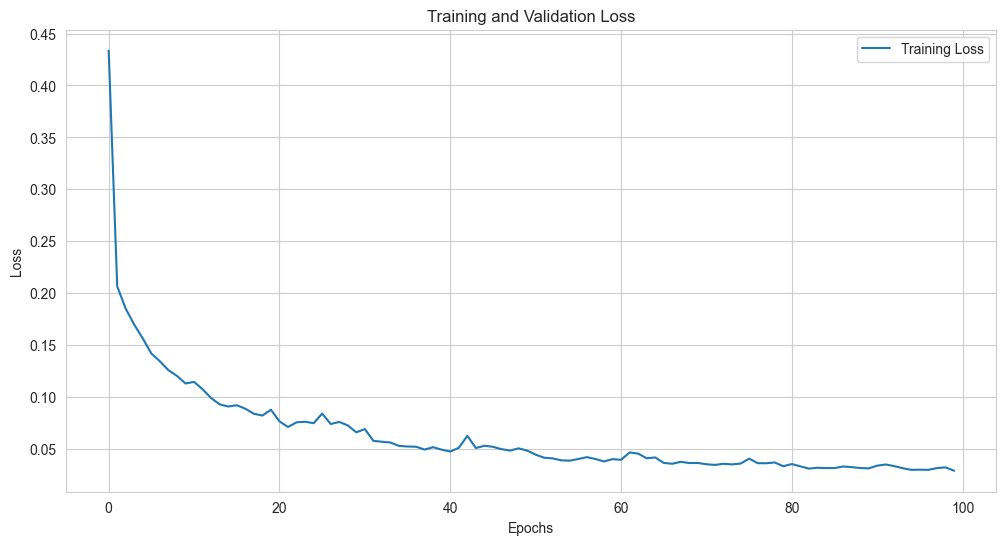

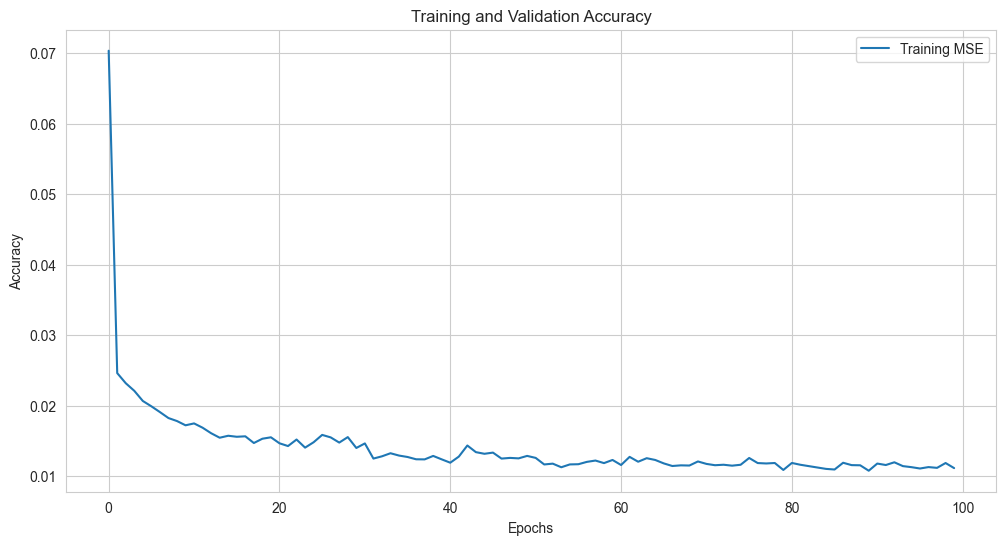

In [15]:
import matplotlib.pyplot as plt

# Extract metrics from history


# Plotting Loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Training Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Accuracy (if available)
if 'mse' in history_dict:  # Use 'acc' if it's an older TensorFlow/Keras version
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict['mse'], label='Training MSE')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [148]:
# Evaluate the model
loss, acc = model_II.evaluate(full_test_II, verbose=2)
print("Untrained model, coherence: {:5.2f}%".format(100 * (1-acc)))

13/13 - 6s - 434ms/step - loss: 0.1238 - mse: 0.0220
Untrained model, coherence: 97.80%


In [149]:
model_II.save(os.path.join(path, 'model_method_II/model.keras'))

In [21]:
print(count_method_II((tf.concat([y for _, y in train_II], axis=0)).numpy().reshape(-1,6)))

16260
       Label  Count Percentage
0      Happy   3828     23.54%
1        Sad   2145     13.19%
2  Disgusted   1587      9.76%
3  Surprised    894       5.5%
4      Angry    896      5.51%
5     Scared    974      5.99%
6    Neutral   7863     48.36%


In [23]:
print(count_method_II((tf.concat([y for _, y in full_test_II], axis=0)).numpy().reshape(-1,6)))

7000
       Label  Count Percentage
0      Happy   1733     24.76%
1        Sad   1020     14.57%
2  Disgusted    764     10.91%
3  Surprised    426      6.09%
4      Angry    286      4.09%
5     Scared    409      5.84%
6    Neutral   3238     46.26%


In [24]:
emotions = ['Happy', 'Sad', 'Scared', 'Disgusted', 'Surprised', 'Angry']

In [27]:
test_set = full_test_II
# Getting predictions (chat)
y_pred = model_II.predict(test_set.map(lambda x, _: x))
y_true = tf.concat([y for _, y in test_set], axis=0)
# Helper function to compute metrics for a single emotion
def compute_all_metrics(y_true, y_pred):
    """
    Compute MAS, MSE, MAE, RMSE, and R² for masked values of y_true and y_pred.
    
    Args:
        y_true (tf.Tensor): Ground truth values after masking.
        y_pred (tf.Tensor): Predicted values after masking.
    
    Returns:
        dict: A dictionary with computed metrics.
    """
    def compute_mse(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred)).numpy()

    def compute_mae(y_true, y_pred):
        return tf.reduce_mean(tf.abs(y_true - y_pred)).numpy()

    def compute_rmse(y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        return tf.sqrt(mse).numpy()

    def compute_r2(y_true, y_pred):
        total_variance = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        residual_variance = tf.reduce_sum(tf.square(y_true - y_pred))
        return (1 - residual_variance / total_variance).numpy()

    def compute_similarity(y_true, y_pred):
        similarity = 1 - tf.abs(y_true - y_pred)
        mas = tf.reduce_mean(similarity).numpy()
        label_count = tf.size(y_true).numpy()
        return mas, label_count

    # Compute metrics
    mse = compute_mse(y_true, y_pred)
    mae = compute_mae(y_true, y_pred)
    rmse = compute_rmse(y_true, y_pred)
    r2 = compute_r2(y_true, y_pred)
    mas, label_count = compute_similarity(y_true, y_pred)

    return {
        'Labels Used': label_count,
        'MAS': mas,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    }

# Main loop to compute metrics for all emotions
def compute_metrics_for_all_emotions(y_true, y_pred, emotions):
    """
    Compute all metrics for each emotion.
    
    Args:
        y_true (tf.Tensor): Ground truth values (shape: [batch_size, sequence_length, num_emotions]).
        y_pred (tf.Tensor): Predicted values (shape: [batch_size, sequence_length, num_emotions]).
        emotions (list): List of emotion names.
    
    Returns:
        list: A list of dictionaries containing metrics for each emotion.
    """
    metric_results = []

    for i, emotion in enumerate(emotions):
        # Extract true and predicted values for the specific emotion
        true_values = tf.cast(y_true[:, :, i], tf.float32)
        pred_values = tf.cast(y_pred[:, :, i], tf.float32)
        
        # Mask non-zero true values
        mask = tf.not_equal(true_values, 0)
        true_values_masked = tf.boolean_mask(true_values, mask)
        pred_values_masked = tf.boolean_mask(pred_values, mask)
        
        # Compute all metrics using the helper function
        metrics = compute_all_metrics(true_values_masked, pred_values_masked)
        metrics['emotion'] = emotion  # Add emotion name to the result
        
        # Append to results
        metric_results.append(metrics)

        # Print for immediate feedback
        print(f"Emotion: {emotion}, Metrics: {metrics}")

    return metric_results

# Example Usage
# Assuming `emotions` is a list of emotion names, and `y_true` and `y_pred` are already defined
results = compute_metrics_for_all_emotions(y_true, y_pred, emotions)

# Results are already printed inside the loop


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step
Emotion: Happy, Metrics: {'Labels Used': 1733, 'MAS': 0.73960924, 'MSE': 0.10900406, 'MAE': 0.26039082, 'RMSE': 0.33015764, 'R²': -0.83478, 'emotion': 'Happy'}
Emotion: Sad, Metrics: {'Labels Used': 1020, 'MAS': 0.7949587, 'MSE': 0.065217994, 'MAE': 0.2050413, 'RMSE': 0.25537813, 'R²': -2.193512, 'emotion': 'Sad'}
Emotion: Scared, Metrics: {'Labels Used': 764, 'MAS': 0.8178042, 'MSE': 0.05166823, 'MAE': 0.18219577, 'RMSE': 0.22730647, 'R²': -0.036802053, 'emotion': 'Scared'}
Emotion: Disgusted, Metrics: {'Labels Used': 426, 'MAS': 0.8025926, 'MSE': 0.050165273, 'MAE': 0.19740742, 'RMSE': 0.22397606, 'R²': -12.885164, 'emotion': 'Disgusted'}
Emotion: Surprised, Metrics: {'Labels Used': 286, 'MAS': 0.805816, 'MSE': 0.051775187, 'MAE': 0.19418405, 'RMSE': 0.22754161, 'R²': -4.8947544, 'emotion': 'Surprised'}
Emotion: Angry, Metrics: {'Labels Used': 409, 'MAS': 0.7948996, 'MSE': 0.057080906, 'MAE': 0.20510055, 'RMSE': 0.2389161, 'R²': -4.9530554, 'e

In [29]:
import pandas as pd
def compute_residuals_for_all_emotions(y_true, y_pred, emotions):
    residuals = pd.DataFrame(columns=emotions)

    for i, emotion in enumerate(emotions):
        # Extract true and predicted values for the specific emotion
        true_values = pd.Series(tf.cast(y_true[:, :, i], tf.float32))
        pred_values = pd.Series(tf.cast(y_pred[:, :, i], tf.float32))
        
        residuals[emotion] = true_values - pred_values
        
    return residuals

# Example Usage
residuals = compute_residuals_for_all_emotions(y_true, y_pred, emotions)
print(residuals.head())

ValueError: Data must be 1-dimensional, got ndarray of shape (350, 20) instead